## Load packages

In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import STAHD

os.environ['R_HOME'] = "/usr/lib/R/"
os.environ['R_USER'] = "~/.conda/envs/STAHD/lib/python3.8/site-packages/rpy2"
            
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Load Data

In [2]:
adata=sc.read_h5ad("/home/dwang/code/STAHI-minibatch/STAHD_CosMx.h5ad")
adata

AnnData object with n_obs × n_vars = 1852946 × 6520
    obs: 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.B', 'Max.B', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'SplitRatioToLocal', 'NucArea', 'NucAspectRatio', 'Circularity', 'Eccentricity', 'Perimeter', 'Solidity', 'cell_id', 'X', 'version', 'dualfiles', 'Run_name', 'Run_Tissue_name', 'ISH.concentration', 'Dash', 'tissue', 'Panel', 'assay_type', 'slide_ID', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantile_0.85', 'falsecode_quantile

In [4]:
# # Constructing the spatial network
# STAHD.Cal_Spatial_Net(adata, rad_cutoff=200)  # the spatial network are saved in adata.uns[‘adj’]
# # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
# adata.uns['edgeList'] = np.nonzero(adata.uns['adj'])
# # Normalization
# # sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
# sc.pp.normalize_total(adata, target_sum=1e4)
# # sc.pp.log1p(adata)
# # adata = adata[:, adata.var['highly_variable']]

------Calculating spatial graph...
The graph contains 64008536 edges, 1852946 cells.
34.5442 neighbors per cell on average.


## Running STAHD

In [3]:
strna = STAHD.train_STAHD(adata, hidden_dims=[50, 30], verbose=True, batch_size=4096, device=used_device)

STAHD(
  (conv1): GATConv(6520, 50, heads=1)
  (conv2): GATConv(50, 30, heads=1)
  (conv3): GATConv(30, 50, heads=1)
  (conv4): GATConv(50, 6520, heads=1)
)
Pretrain with STAHD...


100%|██████████| 1000/1000 [6:02:13<00:00, 21.73s/it] 


## Clustering

In [4]:
leiden_resolution = 0.3
sc.pp.neighbors(strna, use_rep='STAHD', random_state=666)
sc.tl.leiden(strna, random_state=666, key_added="STAHD_leiden", resolution=leiden_resolution)

## Visualization

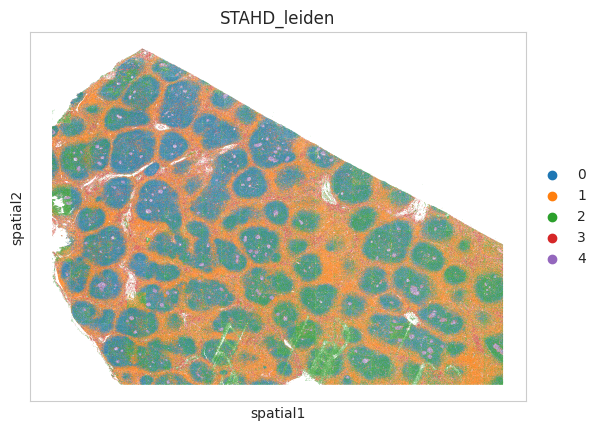

In [5]:
sc.pl.embedding(
    strna,
    color="STAHD_leiden",
    s=0.2,
    basis = 'spatial',
)

In [8]:
cluster_annotation = {
    0: "Germinal Center (B cells)",
    1: "T-cell Zone (T cells)",
    2: "Paracortex (T cells)",
    3: "Lymph Node Stroma (Fibroblasts, Endothelial cells)",
    4: "Proliferative Zone (Activated immune cells)"
}
strna.obs["leiden"] = strna.obs["leiden"].astype(int)
cluster_annotation1 = {i: cluster_annotation[i].split(' (')[0] for i in cluster_annotation}

strna.obs["cluster_annotation"] = strna.obs["leiden"].map(cluster_annotation)
strna.obs["cluster_annotation1"] = strna.obs["leiden"].map(cluster_annotation1)

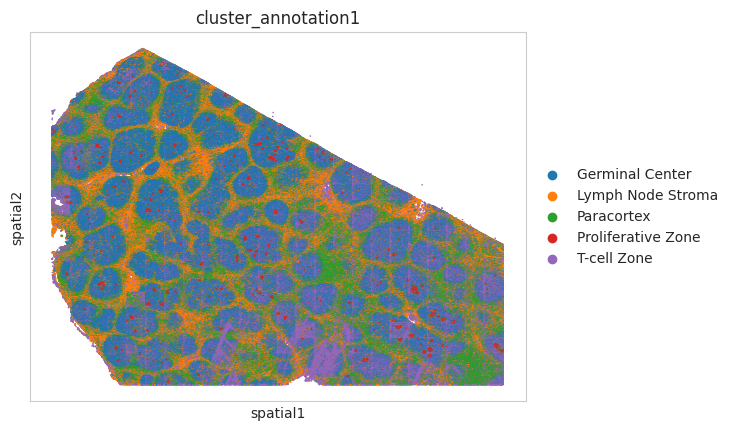

In [11]:
plt.rcParams['font.sans-serif'] = "DejaVu Sans"
sc.pl.embedding(strna,basis='spatial',color='cluster_annotation1',s=5)